In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.0 MB/s 


In [ ]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras

# from keras.utils import normalize
from keras.metrics import MeanIoU
#

In [ ]:
# from segmentation_models import Unet
from segmentation_models import get_preprocessing
# from segmentation_models.losses import bce_jaccard_loss
# from segmentation_models.metrics import iou_score


In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet34

In [ ]:
path = glob.glob("/content/drive/MyDrive/imagesbinary/images binary 500/*.tif")
path.sort()

In [ ]:
path1 = glob.glob("/content/drive/MyDrive/masksbinary500/*.tif")
path1.sort()

In [ ]:
#Resizing images, if needed
SIZE_X = 128
SIZE_Y = 128
n_classes=2

In [ ]:
# SIZE_X = 128 #Resize images (height  = X, width = Y)
# SIZE_Y = 128

#Capture training image info as a list
train_images = []
for img_path in path:
  #print(img_path)
  img = cv2.imread(img_path,1)
  img = cv2.resize(img, (SIZE_Y, SIZE_X),interpolation = cv2.INTER_NEAREST)
  # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  train_images.append(img)
  #train_labels.append(label)
#Convert list to array for machine learning processing

train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = []
for img_path1 in path1:
  mask = cv2.imread(img_path1, 0)
  mask = cv2.resize(mask, (SIZE_Y, SIZE_X),interpolation = cv2.INTER_NEAREST)
  #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
  train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing


train_masks = np.array(train_masks)

In [ ]:
np.unique(train_masks)

array([  0, 255], dtype=uint8)

In [ ]:

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1])

In [ ]:
#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)


In [ ]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled


Class values in the dataset are ...  [0 1]


In [ ]:
activation='softmax'

In [ ]:
import tensorflow as tf

train_masks_cat = tf.keras.utils.to_categorical (y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



# train_masks_cat = tf.keras.utils.to_categorical (y_train, num_classes=n_classes)

# y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


In [ ]:

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (2 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


#

In [ ]:

########################################################################
###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())



In [ ]:

history1=model1.fit(X_train1,
          y_train_cat,
          batch_size=8,
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))



In [ ]:

model1.save('/content/drive/MyDrive/0_epoch_weights/res34_backbone_50epochs.hdf5')

In [ ]:

###
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#####################################################
acc = history1.history['f1-score']
val_acc = history1.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()


In [ ]:

from keras.models import load_model

### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('/content/drive/MyDrive/0_epoch_weights/res34_backbone_50epochs.hdf5', compile=False)
# model2 = load_model('saved_models/inceptionv3_backbone_50epochs.hdf5', compile=False)
# model3 = load_model('saved_models/vgg19_backbone_50epochs.hdf5', compile=False)

#IOU
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)



In [ ]:

#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1]  + values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[0,1])
# class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
# class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
# print("IoU for class3 is: ", class3_IoU)
# print("IoU for class4 is: ", class4_IoU)


Mean IoU = 0.4944985
[[8.7804e+04 9.2800e+02 9.6000e+01]
 [3.5430e+03 4.4850e+03 7.1000e+01]
 [5.7100e+02 6.8700e+02 1.1900e+02]]


IndexError: ignored

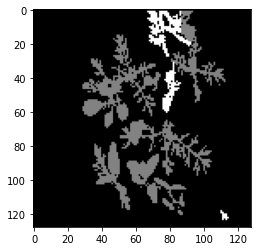

In [ ]:

#Vaerify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')
##############################################################

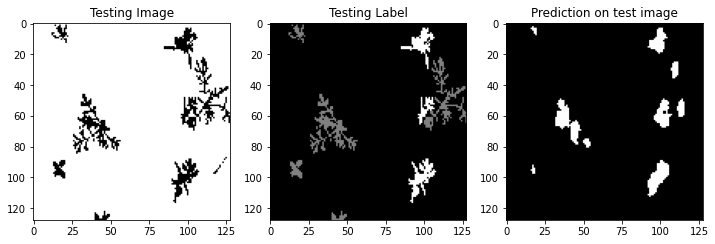

In [ ]:

# Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

In [ ]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code



In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)
# define model

In [ ]:
type(x_train)

In [ ]:
# define model
model = Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

print(model.summary())

In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
#from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training (callbacks=[PlotLossesKeras()],)
model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=2000,
   verbose=1,
   validation_data=(x_val, y_val),
)